In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import time
import warnings
import cv2
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import albumentations as A
import matplotlib.pyplot as plt
import PIL
import os, glob, shutil
from PIL import Image


warnings.filterwarnings("ignore")

In [ ]:
!pip install git+https://github.com/yxxshin/yxx_change_detection.pytorch > /dev/null 2>&1
import change_detection_pytorch as cdp

In [ ]:
import change_detection_pytorch as cdp

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [ ]:
## TODO
DATASET_PATH = '/content/drive/MyDrive/MAICON_prefinal/datasets/'

In [ ]:
def make_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
import zipfile
from tqdm import tqdm

make_dir('/content/datasets/')
make_dir('/content/datasets/train/')
#make_dir('/content/datasets/train/y2')
make_dir('/content/datasets/train/y2_train_x1')
make_dir('/content/datasets/train/y2_train_x2')
make_dir('/content/datasets/val/')
#make_dir('/content/datasets/val/y2')
make_dir('/content/datasets/val/y2_train_x1')
make_dir('/content/datasets/val/y2_train_x2')

with zipfile.ZipFile(DATASET_PATH + 'trainOneHot/train_y2_mask1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_mask1')

      
with zipfile.ZipFile(DATASET_PATH + 'trainOneHot/train_y2_mask3.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_mask3')

with zipfile.ZipFile(DATASET_PATH + 'trainOneHot/train_y2_train_x1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_train_x1')

with zipfile.ZipFile(DATASET_PATH + 'trainOneHot/train_y2_train_x2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/train/y2_train_x2')





with zipfile.ZipFile(DATASET_PATH + 'valOneHot/val_y2_mask1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_mask1')


with zipfile.ZipFile(DATASET_PATH + 'valOneHot/val_y2_mask3.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_mask3')


with zipfile.ZipFile(DATASET_PATH + 'valOneHot/val_y2_train_x1.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_train_x1')

with zipfile.ZipFile(DATASET_PATH + 'valOneHot/val_y2_train_x2.zip') as zf:
  for member in tqdm(zf.infolist(), desc = 'Extracting  '):
      zf.extract(member, '/content/datasets/val/y2_train_x2')


Extracting  : 100%|██████████| 2324/2324 [00:13<00:00, 174.58it/s]


In [ ]:
def seed_torch(seed):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch(seed = 10)

In [ ]:
from matplotlib import colors

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

In [ ]:
from change_detection_pytorch.datasets.custom import CustomDataset

class SatelliteDataset(CustomDataset):
  def __init__(self, img_dir, sub_dir_1, sub_dir_2, ann_dir, img_suffix, 
               seg_map_suffix, transform = None, split = None, data_root = None, test_mode = False, size = 256, debug = False):
    super().__init__(img_dir, sub_dir_1, sub_dir_2, ann_dir, img_suffix,
                     seg_map_suffix, transform, split, data_root, test_mode, size, debug)
    
  def get_default_transform(self):
    """ Default Transformation (Train data) """
    
    default_transform = A.Compose([
        A.OneOf(
            [
              A.HorizontalFlip(p = 1),
              A.VerticalFlip(p = 1),
              A.RandomRotate90(p = 1),
            ],
            p = 0.75,
        ),
        # A.CLAHE(clip_limit = (1, 15), tile_grid_size = (8, 8), p = 1),
        #A.Equalize(always_apply = True, mode = 'cv', by_channels = False),
        # A.GaussNoise(always_apply = False, p = 0.5, var_limit = (0.0, 26.85)),
        #A.Resize(256, 256),
        A.OneOf(
          [
              A.RandomSizedCrop(min_max_height = [512, 512], height = 256, width = 256, p = 0.2),
              A.Resize(256, 256, p = 0.8)
          ],
          p = 1,
        ),
        A.GaussNoise(always_apply = False, p = 0.3, var_limit = (0.0, 26.85)),
        A.pytorch.ToTensorV2()
    ], additional_targets = {'image_2': 'image'})

    return default_transform
  
  def get_test_transform(self):
    """ Test Transformation """
    
    test_transform = A.Compose([
        #A.Equalize(always_apply = True, mode = 'cv', by_channels = False),
        A.Resize(256, 256),
        A.pytorch.ToTensorV2()
    ], additional_targets = {'image_2': 'image'})

    return test_transform
  

  def __getitem__(self, idx):
    if not self.ann_dir:
      # Test Data
      img1, img2, fname = self.prepare_img(idx)
      transformed_data = self.transform(image = img1, image_2 = img2)
      img1, img2 = transformed_data['image'], transformed_data['image_2']
      img1 = img1.type(torch.FloatTensor)
      img2 = img2.type(torch.FloatTensor)
      return img1, img2, fname
    
    else:
      img1, img2, ann, fname = self.prepare_img_ann(idx)
      transformed_data = self.transform(image = img1, image_2 = img2, mask = ann)
      img1, img2, ann = transformed_data['image'], transformed_data['image_2'], transformed_data['mask']
      img1 = img1.type(torch.FloatTensor)
      img2 = img2.type(torch.FloatTensor)
      ann = ann.type(torch.FloatTensor)
      return img1, img2, ann, fname


In [ ]:
train_y2_dataset = SatelliteDataset('/content/datasets/train',
                                sub_dir_1 = 'y2_train_x1',
                                sub_dir_2 = 'y2_train_x2',
                                img_suffix = '.png',
                                ann_dir = '/content/datasets/train/y2_mask1',
                                seg_map_suffix = '.png',
                                size = 754,
                                debug = False)

valid_y2_dataset = SatelliteDataset('/content/datasets/val',
                                 sub_dir_1 = 'y2_train_x1',
                                 sub_dir_2 = 'y2_train_x2',
                                 img_suffix = '.png',
                                 ann_dir = '/content/datasets/val/y2_mask1',
                                 seg_map_suffix = '.png',
                                 size = 754,
                                 debug = False,
                                 test_mode = True)

Loaded 9273 images
Loaded 2324 images


In [ ]:
train_y2_loader = DataLoader(train_y2_dataset, batch_size = 4, shuffle = False, num_workers = 0)
valid_y2_loader = DataLoader(valid_y2_dataset, batch_size = 1, shuffle = False, num_workers = 0)

2017_JLG_2LB_000608.png
torch.Size([256, 256])
torch.Size([3, 256, 256])


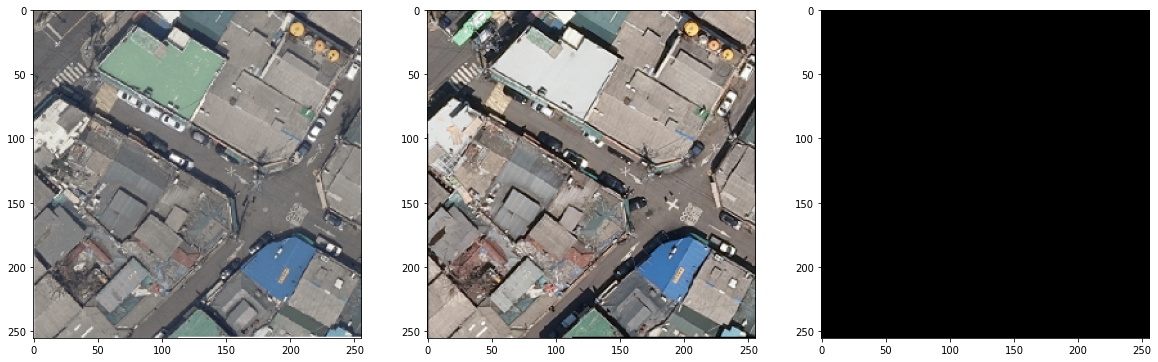

In [ ]:
# DataLoader Sanity Check

test = next(iter(train_y2_loader))


test_x1, test_x2, test_y, test_filename = test
test_y = test_y * 255

# Change back to uint8 for visualization
test_x1 = test_x1.type(torch.ByteTensor)
test_x2 = test_x2.type(torch.ByteTensor)
test_y = test_y.type(torch.ByteTensor)


print(test_filename[0]) 
print(test_y[0].shape)    # [256, 256]
print(test_x1[0].shape)   # [3, 256, 256]

plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(test_x1[1].permute(1, 2, 0))

plt.subplot(132)
plt.imshow(test_x2[1].permute(1, 2, 0))

plt.subplot(133)
plt.imshow(test_y[1], cmap = discrete_cmap(4, 'afmhot'))
plt.show()

In [ ]:
## TRAINING START

metrics = [
    cdp.utils.metrics.Accuracy(activation = 'argmax2d'),
    cdp.utils.metrics.IoU(activation = 'argmax2d')
]

In [ ]:
from change_detection_pytorch.unetplusplus.model import UnetPlusPlus
from change_detection_pytorch.stanet.model import STANet

# model_y1 = Unet(`
#     encoder_name = 'timm-efficientnet-b7',
#     encoder_depth = 5,
#     encoder_weights = 'noisy-student',
#     in_channels = 3,
#     classes = 4,
#     siam_encoder = True,
#     fusion_form = 'diff',
#     decoder_channels = [384, 256, 128, 64, 32],
#     head = 'cond'
# )

# model_y2 = UnetPlusPlus(
#     encoder_name = 'timm-efficientnet-b0',
#     encoder_weights = 'noisy-student',
#     in_channels = 3,
#     classes = 2
# )


model_y2 = UnetPlusPlus(
    encoder_name = 'timm-efficientnet-b0',
    encoder_depth = 5,
    encoder_weights = 'noisy-student',
    in_channels = 3,
    classes = 2,
)

#model_y2 = torch.load('/content/best_model_y2_mask1_gen5.pth')


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [ ]:
### train_y2

def train_by_wandb_y2():
  # wandb.init(project = 'MAICON', entity = 'maicon-rokdcc')
  
  train_loader = DataLoader(train_y2_dataset, batch_size = 16, shuffle = True, num_workers = 0)
  valid_loader = DataLoader(valid_y2_dataset, batch_size = 1, shuffle = False, num_workers = 0)

  # model = torch.load('/workspace/data/03_MaechuriAI/best_model_y2.pth')

  loss1 = cdp.losses.JaccardLoss(mode = 'multiclass')
  loss2 = cdp.losses.DiceLoss(mode = 'multiclass')
  loss = cdp.losses.HybridLoss(loss1, loss2)
    
  optimizer = optim.AdamW([
      dict(params = model_y2.parameters(), lr = 0.001)
  ])

  epochs = 50

  scheduler_steplr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000, eta_min = 0, last_epoch = -1, verbose = False)
    
  train_epoch = cdp.utils.train.TrainEpoch(
      model_y2,
      loss = loss,
      metrics = metrics,
      optimizer = optimizer,
      device = DEVICE,
      verbose = True,
  )

  valid_epoch = cdp.utils.train.ValidEpoch(
      model_y2,
      loss = loss,
      metrics = metrics,
      device = DEVICE,
      verbose = True,
  )

  min_score = 1000
  MAX_EPOCH = epochs

  for i in range(1, MAX_EPOCH + 1):
    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)  
    valid_logs = valid_epoch.run(valid_loader)
    scheduler_steplr.step()
    print('train_logs ', train_logs)
    print('valid_logs ', valid_logs)

    # wandb.log({
    #     'epoch': i,
    #     'train_fscore': train_logs['fscore'],
    #     'train_loss': train_logs['JaccardLoss'],
    #     'train_iou': train_logs['iou_score'],
    #     'val_fscore': valid_logs['fscore'],
    #     'val_loss': valid_logs['JaccardLoss'],
    #     'val_iou': valid_logs['iou_score']
    # })

    if min_score > valid_logs['HybridLoss']:
      min_score = valid_logs['HybridLoss']
      print('min_loss', min_score)
      torch.save(model_y2, './best_model_y2_mask1.pth')
      print('Model saved!')


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_by_wandb_y2()


Epoch: 1
valid: 100%|██████████| 2324/2324 [03:24<00:00, 11.36it/s, HybridLoss - 0.05192, accuracy - 0.9898, iou_score - 0.7728]
train_logs  {'HybridLoss': 0.34773612520818076, 'accuracy': 0.9773327961050221, 'iou_score': 0.19157517084017286}
valid_logs  {'HybridLoss': 0.051920946777225974, 'accuracy': 0.9897903928247873, 'iou_score': 0.772823662398992}
min_loss 0.051920946777225974
Model saved!

Epoch: 2
valid: 100%|██████████| 2324/2324 [03:23<00:00, 11.41it/s, HybridLoss - 0.0444, accuracy - 0.9857, iou_score - 0.7175]
train_logs  {'HybridLoss': 0.2978761963546273, 'accuracy': 0.987043658104436, 'iou_score': 0.25992751061003344}
valid_logs  {'HybridLoss': 0.044398657240217174, 'accuracy': 0.9856739930564901, 'iou_score': 0.7175051424992321}
min_loss 0.044398657240217174
Model saved!

Epoch: 3
valid: 100%|██████████| 2324/2324 [03:22<00:00, 11.50it/s, HybridLoss - 0.04124, accuracy - 0.9895, iou_score - 0.7627]
train_logs  {'HybridLoss': 0.2823250418336228, 'accuracy': 0.98813209245